## Nested clustering of cells in the HLCA, and cluster differential expression analysis (DEA)

In this notebook we perform multi-level clustering of the cells in the HLCA (including final HLCA and benchmarking integrated HLCA subsets). We start with coarse-resolution clustering, and then re-cluster the resulting clusters by first re-calculating the nearest-neighbor graph and then clustering each cluster, with a finer resolution. For the final HLCA, we also calculate marker genes for every cluster. These will be used during manual annotation of the HLCA.

### Import modules, set paths, select atlas version to cluster:

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import sys
import os

sys.path.append("../../scripts/")
import nested_clustering
import analysis

For pretty coding, not necessary to run code:

In [2]:
%load_ext lab_black

Set paths:

In [3]:
dir_benchmarking_res = (
    "../../results/integration_benchmarking/benchmarking_results/integration/"
)
dir_benchmarking_cluster_output = "../../results/integration_benchmarking/clustering/"

path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v2_intermediates/LCA_Bano_Barb_Jain_Kras_Lafy_Meye_Mish_MishBud_Nawi_Seib_Teic_log1p.h5ad"  # Note: v2 instead of v1 --> new clustering added for revisions
dir_HLCA_cluster_output = "../../results/DEAs/leiden/"

Select data to work with. We clustered the final HLCA using this notebook, but also other atlas integration generated during our integration benchmarking. We will use the clusters of the benchmarking output later to study rare cell identification with different integration methods. Choose one of the 4 lines below:

In [4]:
dataset_name = "HLCA"  # final, full HLCA
# dataset_name = "harmony"  # benchmark
# dataset_name = "seuratrpca"  # benchmark
# dataset_name = "scanvi"  # benchmark

Set number of cluster levels (we used 3 for benchmark methods and for final atlas, and 4 for the full HLCA)

In [5]:
number_of_clust_levels = 4

### Load data and perform clustering:

Load the optimal integration for each of the benchmarking methods included, or the final atlas:

In [6]:
print("Dataset name:", dataset_name)
if dataset_name == "scanvi":
    # load dataset
    adata = sc.read(os.path.join(dir_benchmarking_res, "unscaled/hvg/scanvi.h5ad"))
    # specify which obsm to use for calculating neighbor graph
    use_rep = "X_emb"
    # specify whether or not to re-calculate the PCA for subsets of the object
    redo_pca = False
elif dataset_name == "seuratrpca":
    adata = sc.read(
        os.path.join(dir_benchmarking_res, "unscaled/hvg/R/seuratrpca.h5ad")
    )
    sc.tl.pca(adata)
    use_rep = "X_pca"
    redo_pca = True
elif dataset_name == "harmony":
    adata = sc.read(os.path.join(dir_bencmarking_res, "scaled/hvg/R/harmony.h5ad"))
    adata.obsm["X_pca"] = adata.obsm["X_emb"]
    use_rep = "X_emb"
    redo_pca = False
elif dataset_name == "HLCA":
    adata = sc.read(path_HLCA)
    use_rep = "X_scanvi_emb"
    redo_pca = False

Dataset name: HLCA


visualize if a umap is available:

In [ ]:
if "X_umap" in adata.obsm.keys():
    if "scanvi_labels" in adata.obs.columns:
        sc.pl.umap(adata, color="scanvi_labels")
    elif "scgen_labels" in adata.obs.columns:
        sc.pl.umap(adata, color="scgen_labels")

Perform multi-level clustering:

In [ ]:
for clustering_level in range(1, number_of_clust_levels + 1):
    print("clustering level:", clustering_level, "...")
    if clustering_level == 1:
        # skip for re-run
        cluster_name = "leiden_1"
        # first clustering is not nested, so use normal function:
        sc.pp.neighbors(adata, n_neighbors=30, use_rep=use_rep)
        sc.tl.leiden(adata, resolution=0.01, key_added=cluster_name)
    else:
        previous_clustering = "leiden_" + str(clustering_level - 1)
        cluster_name = "leiden_" + str(clustering_level)
        #         perform nested clustering
        #         set parameters:
        res = 0.2
        if clustering_level == 2:
            k = 30
            min_cluster_size = 50
        elif clustering_level == 3:
            k = 15
            min_cluster_size = 30
        elif clustering_level == 4:
            k = 10
            min_cluster_size = 10

        adata = nested_clustering.add_nested_clustering_blind(
            adata,
            previous_clustering,
            cluster_name,
            use_rep=use_rep,
            cluster_alg="leiden",
            cluster_k=k,
            cluster_res=res,
            min_cluster_size=min_cluster_size,
            redo_pca=redo_pca,  # SET THIS TO FALSE FOR SCANVI!!! OR OTHER EMBEDDING-OUTPUT METHODS!!!!!
        )
    # plot
    if "X_umap" in adata.obsm.keys():
        sc.pl.umap(adata, color=cluster_name)
    # store clustering:
    cluster_df = pd.DataFrame(adata.obs[cluster_name], index=adata.obs.index)
    # write to csv for benchmarking data:
    if dataset_name in ["harmony","scanvi","seuratrpca"]:
        cluster_df.to_csv(
            os.path.join(dir_benchmarking_cluster_output, f"{dataset_name}/{dataset_name}_{cluster_name}_cluster_assignment.csv")
        )
    # If wanted/needed, for final HLCA:
    if dataset_name == "HLCA":
        # store cluster assignments:
        cluster_df.to_csv(
            os.path.join(dir_HLCA_cluster_output, f"LCA_{cluster_name}_cluster_assignment.csv")
        )
        # calculate marker genes with respect to all other clusters, and with respect to sister clusters (i.e. other cluster from the same parent cluster):
        for marker_ref in ["sisters", "all"]:
            marker_gene_df = nested_clustering.get_cluster_markers(
                adata=adata,
                cluster_label=cluster_name,
                marker_ref=marker_ref,
                ngenes=100,
            )
            # and store:
            marker_gene_df.to_csv(
                os.path.join(dir_HLCA_cluster_output, f"LCA_{cluster_name}_marker_genes_versus_{marker_ref}.csv")
            )

#### manual level 5 clustering where needed:

Cluster 1.2.1.2 in the HLCA, contains two different types of DCs, hence we re-cluster this level four cluster to get level 5 clusters for this specific case. 
Same for cluster 0.4.1.0, which contains AT0 cells, and 0.4.1.1, which contain "pre-terminal-bronchiole-secretory cells".

In [7]:
cls_to_recluster = [
    "0.4.1.0",
    "0.4.1.1",
]  # , "1.2.1.2"] only doing the first 2 as extra for the revisions, 1.2.1.2 was already run previously

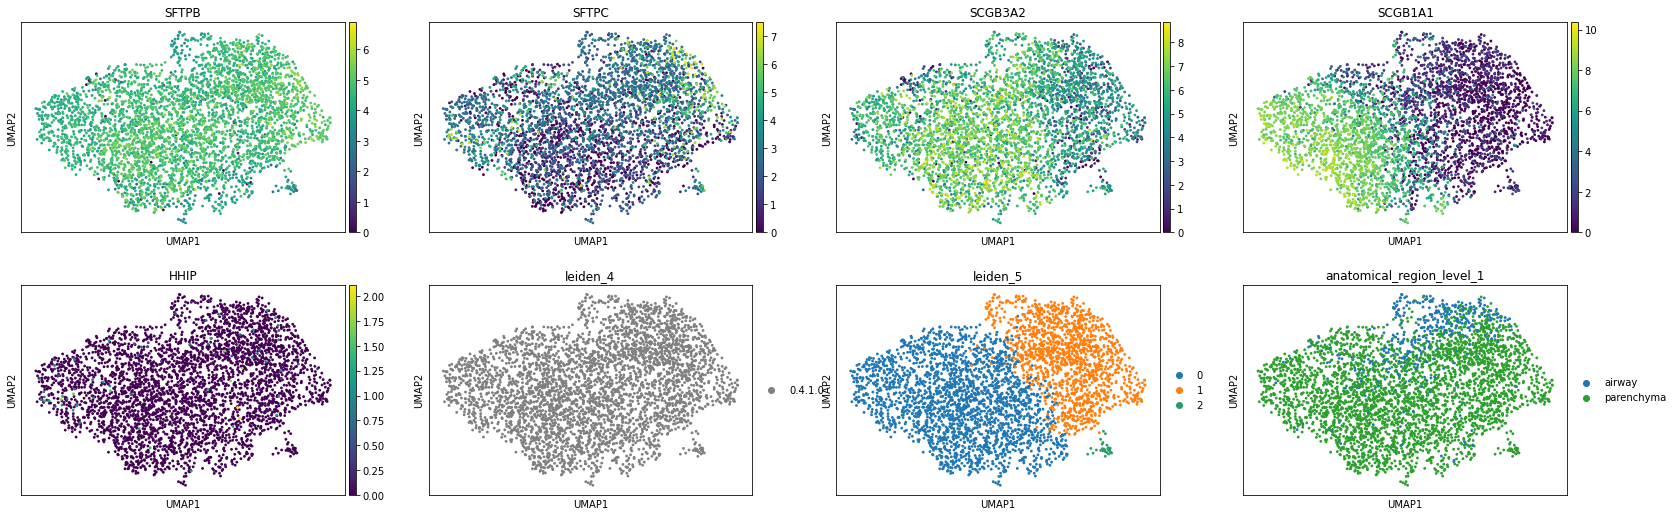

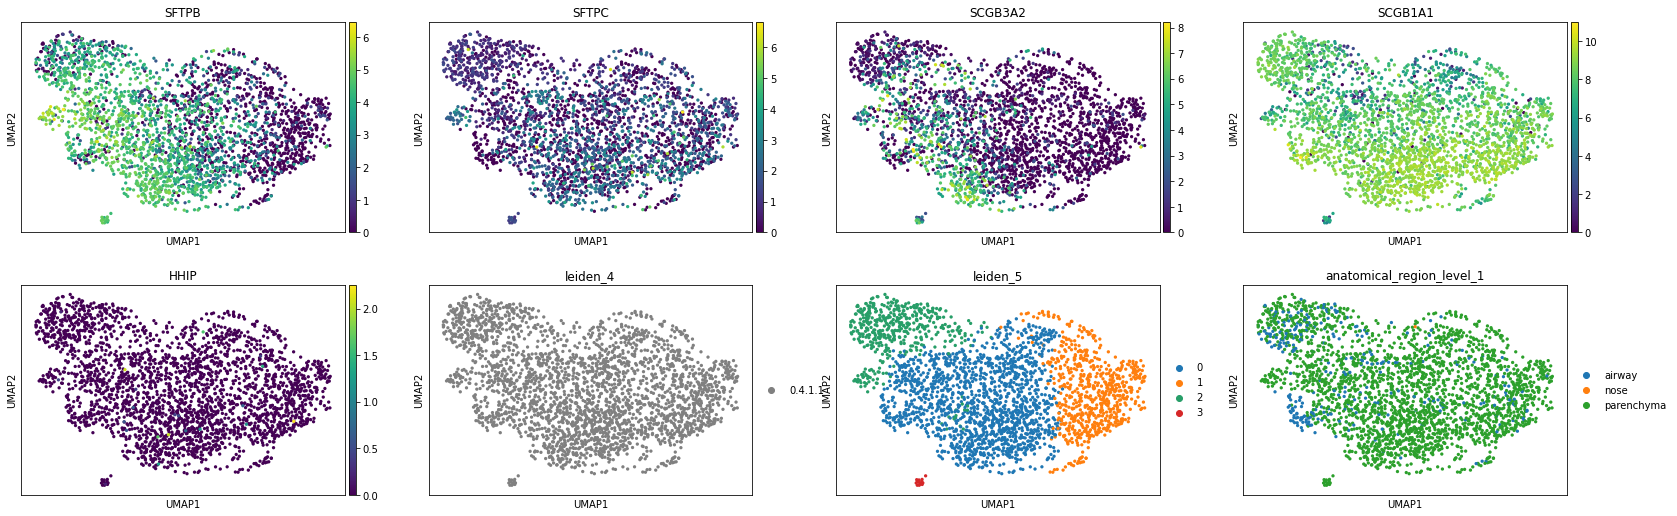

In [8]:
if dataset_name == "HLCA":
    for cl_to_recluster in cls_to_recluster:
        subadata = adata[adata.obs.leiden_4 == cl_to_recluster, :].copy()
        sc.pp.neighbors(subadata, n_neighbors=10, use_rep="X_scanvi_emb")
        sc.tl.umap(subadata)
        sc.tl.leiden(subadata, resolution=0.2, key_added="leiden_5")
        # plot and check which cluster is which:
        if cl_to_recluster == "1.2.1.2":
            sc.pl.umap(subadata, color=["CLEC9A", "CCR7", "leiden_4", "leiden_5"])
        elif cl_to_recluster in ["0.4.1.0", "0.4.1.1"]:
            sc.pl.umap(
                subadata,
                color=[
                    "SFTPB",
                    "SFTPC",
                    "SCGB3A2",
                    "SCGB1A1",
                    "HHIP",
                    "leiden_4",
                    "leiden_5",
                    "anatomical_region_level_1",
                ],
            )
        # add clustering info to main object
        if "leiden_5" not in adata.obs.columns:
            adata.obs["leiden_5"] = np.nan
        else:
            adata.obs["leiden_5"] = list(adata.obs.leiden_5)
        adata.obs.loc[subadata.obs.index, "leiden_5"] = [
            f"{l4}.{l5}" for l4, l5 in zip(subadata.obs.leiden_4, subadata.obs.leiden_5)
        ]

In [13]:
del adata.uns["leiden_4_colors"]

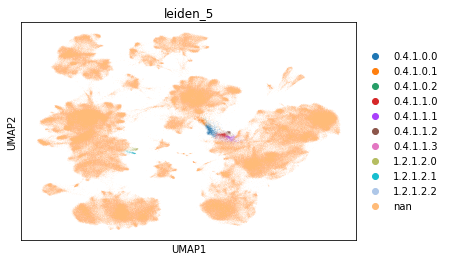

In [15]:
if dataset_name == "HLCA":
    # some plots for final checks:
    sc.pl.umap(adata, color="leiden_5")

### Calculate cluster entropies for several obs variables:

In [10]:
for obs_variable in [
    "subject_ID",
    "dataset",
    "original_ann_level_1",
    "original_ann_level_2_clean",
    "original_ann_level_3_clean",
]:
    analysis.calculate_cluster_entropy(
        adata, cluster_variable="leiden_3", obs_variable=obs_variable
    )

Storing entropy values in obs column entropy_subject_ID_leiden_3
Storing entropy values in obs column entropy_dataset_leiden_3
Storing entropy values in obs column entropy_original_ann_level_1_leiden_3
Storing entropy values in obs column entropy_original_ann_level_2_clean_leiden_3
Storing entropy values in obs column entropy_original_ann_level_3_clean_leiden_3


/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


For HLCA: correct color glitches for cellxgene proper functioning, and store final adata

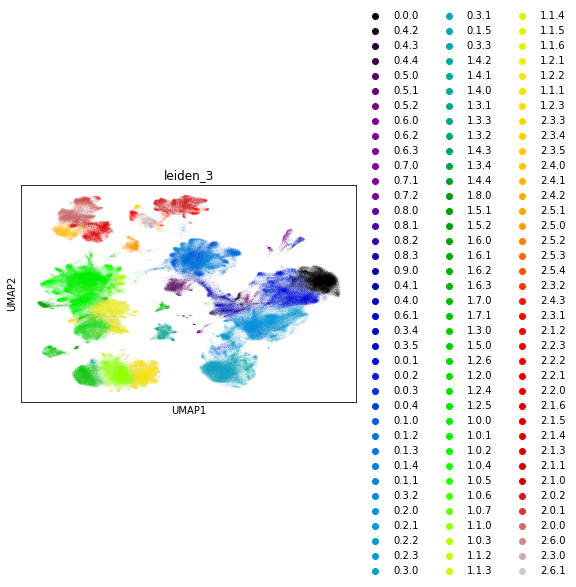

In [11]:
if dataset_name == "HLCA":
    # make leiden 2 strings:
    adata.obs["leiden_2"] = pd.Categorical(adata.obs.leiden_2.astype(str))
    # and to add colors for leiden_3:
    sc.pl.umap(adata, color="leiden_3", palette="nipy_spectral")
    # store:
    adata.write(path_HLCA)